# Pytorch implement of Arcface 

In [1]:
from __future__ import print_function
from __future__ import division
import cv2
import os  
import numpy as np             
import matplotlib.pyplot as plt                        
%matplotlib inline 

from os import listdir
from PIL import Image
from numpy import asarray

import math
import torch
from torch import nn
from torch.optim import Adam
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision import transforms as T
from torch.optim.lr_scheduler import StepLR
import time
from torch.nn import Parameter

import torch.optim as optim
import torchvision
from torchvision import models
from torch.autograd import Variable

import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.4.0
Torchvision Version:  0.5.0


# A - prepare dataset

## 1- Face detection and extraction 
Algorithm that check if images contain faces and 5 landmarks (two eyes, nose and
mouth corners) then all faces are cropped to 112 × 96 RGB images and saved in Faces file

In [6]:
# load color (BGR) image
human_files = np.array(glob("data/CACD2000/*.jpg"))
print('There are %d total human images.' % len(human_files))


There are 163446 total human images.


In [7]:
detector = MTCNN()

In [44]:
def face_extractor(origin, destination):
    ## Importing image using open cv
    img = cv2.imread(origin,1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ## Resizing to constant width
    img = imutils.resize(img, width=200)
    
    ## Finding actual size of image
    H,W,_ = img.shape
    result = detector.detect_faces(img)
    if result :
        
        # Result is an array with all the bounding boxes detected.
        bounding_box = result[0]['box']
    
        #keypoints = result[0]['keypoints'] 
    
        X, Y, w, h = bounding_box[0] ,bounding_box[1],bounding_box[2],bounding_box[3]
    
        #cv2.rectangle(image,
        #          (bounding_box[0], bounding_box[1]),
        #          (bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
        #          (0,155,255),
        #          2)

        #cv2.circle(image,(keypoints['left_eye']), 2, (0,155,255), 2)
        #cv2.circle(image,(keypoints['right_eye']), 2, (0,155,255), 2)
        #cv2.circle(image,(keypoints['nose']), 2, (0,155,255), 2)
        #cv2.circle(image,(keypoints['mouth_left']), 2, (0,155,255), 2)
        #cv2.circle(image,(keypoints['mouth_right']), 2, (0,155,255), 2)

        #cv2.imwrite("ivan_drawn.jpg", cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    
        ## Crop and export the image
        img_cp = img[
            max(0,Y - int(0.35*h)): min(Y + int(1.35*h), H),
            max(0,X - int(w*0.35)): min(X + int(1.35*w), W)
        ].copy()
        
    
        img_cp  = cv2.cvtColor(img_cp, cv2.COLOR_RGB2BGR)
        # resize image
        dim = (96, 112)
        img = cv2.resize(img_cp, dim)
        
        cv2.imwrite(destination+org.split('/')[-1] ,img )
 

In [45]:
## Defining destination path
path = 'data/Faces/'
## Will run for about an hour and a half 
for org in tqdm_notebook(human_files):
    face_extractor(origin = org, destination = path)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


## 2- Organize images to label  folder

In [46]:
image_dir  = 'data/Faces' 

In [47]:
images = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

for image in tqdm_notebook(images):
    folder_name = image.split('_')[1] + " " + image.split('_')[2]
    new_path = os.path.join(image_dir, folder_name)
    if not os.path.exists(new_path):
        os.makedirs(new_path)
    old_image_path = os.path.join(image_dir, image)
    new_image_path = os.path.join(new_path, image)
    shutil.move(old_image_path, new_image_path)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


## 3- Splite dataset  to train/test folder

In [48]:
!pip install split-folders

In [56]:
import split_folders

In [57]:
split_folders.ratio('data/Faces', output="data/Dataset", seed=1337, ratio=(.8, .2)) # default values




Copying files: 0 files [00:00, ? files/s]


Copying files: 24 files [00:00, 239.98 files/s]


Copying files: 109 files [00:00, 305.70 files/s]


Copying files: 233 files [00:00, 394.97 files/s]


Copying files: 341 files [00:00, 487.64 files/s]


Copying files: 444 files [00:00, 578.93 files/s]


Copying files: 542 files [00:00, 658.81 files/s]


Copying files: 629 files [00:00, 691.00 files/s]


Copying files: 714 files [00:00, 723.26 files/s]


Copying files: 826 files [00:00, 808.73 files/s]


Copying files: 923 files [00:01, 849.77 files/s]


Copying files: 1023 files [00:01, 889.77 files/s]


Copying files: 1146 files [00:01, 969.09 files/s]


Copying files: 1250 files [00:01, 915.21 files/s]


Copying files: 1347 files [00:01, 837.79 files/s]


Copying files: 1436 files [00:01, 804.49 files/s]


Copying files: 1521 files [00:01, 802.40 files/s]


Copying files: 1614 files [00:01, 836.78 files/s]


Copying files: 1700 files [00:01, 726.56 files/s]


Copying files: 1777 files [0

Copying files: 20826 files [00:29, 799.67 files/s]


Copying files: 20911 files [00:29, 814.03 files/s]


Copying files: 20994 files [00:29, 769.47 files/s]


Copying files: 21078 files [00:29, 787.91 files/s]


Copying files: 21162 files [00:30, 802.43 files/s]


Copying files: 21243 files [00:30, 742.35 files/s]


Copying files: 21328 files [00:30, 770.21 files/s]


Copying files: 21410 files [00:30, 784.08 files/s]


Copying files: 21491 files [00:30, 790.30 files/s]


Copying files: 21571 files [00:30, 721.88 files/s]


Copying files: 21645 files [00:30, 698.36 files/s]


Copying files: 21725 files [00:30, 725.97 files/s]


Copying files: 21802 files [00:30, 737.07 files/s]


Copying files: 21877 files [00:31, 724.32 files/s]


Copying files: 21960 files [00:31, 751.20 files/s]


Copying files: 22042 files [00:31, 768.40 files/s]


Copying files: 22120 files [00:31, 731.56 files/s]


Copying files: 22203 files [00:31, 756.82 files/s]


Copying files: 22290 files [00:31, 785.46 file

Copying files: 43170 files [00:58, 765.63 files/s]


Copying files: 43256 files [00:58, 790.36 files/s]


Copying files: 43337 files [00:58, 759.19 files/s]


Copying files: 43426 files [00:58, 793.49 files/s]


Copying files: 43507 files [00:58, 797.12 files/s]


Copying files: 43588 files [00:58, 728.19 files/s]


Copying files: 43678 files [00:59, 761.61 files/s]


Copying files: 43756 files [00:59, 736.02 files/s]


Copying files: 43839 files [00:59, 760.30 files/s]


Copying files: 43917 files [00:59, 715.67 files/s]


Copying files: 43996 files [00:59, 735.34 files/s]


Copying files: 44071 files [00:59, 719.72 files/s]


Copying files: 44144 files [00:59, 686.63 files/s]


Copying files: 44220 files [00:59, 706.83 files/s]


Copying files: 44308 files [00:59, 751.14 files/s]


Copying files: 44385 files [01:00, 712.52 files/s]


Copying files: 44458 files [01:00, 701.68 files/s]


Copying files: 44544 files [01:00, 741.18 files/s]


Copying files: 44620 files [01:00, 715.87 file

Copying files: 64326 files [01:27, 686.62 files/s]


Copying files: 64407 files [01:27, 718.07 files/s]


Copying files: 64484 files [01:27, 724.28 files/s]


Copying files: 64558 files [01:27, 718.11 files/s]


Copying files: 64642 files [01:28, 748.79 files/s]


Copying files: 64718 files [01:28, 751.42 files/s]


Copying files: 64794 files [01:28, 702.72 files/s]


Copying files: 64877 files [01:28, 734.58 files/s]


Copying files: 64957 files [01:28, 752.36 files/s]


Copying files: 65035 files [01:28, 757.49 files/s]


Copying files: 65116 files [01:28, 771.36 files/s]


Copying files: 65194 files [01:28, 748.86 files/s]


Copying files: 65270 files [01:28, 713.46 files/s]


Copying files: 65346 files [01:29, 724.81 files/s]


Copying files: 65421 files [01:29, 731.64 files/s]


Copying files: 65495 files [01:29, 711.46 files/s]


Copying files: 65567 files [01:29, 692.27 files/s]


Copying files: 65643 files [01:29, 710.25 files/s]


Copying files: 65715 files [01:29, 686.59 file

Copying files: 85317 files [01:56, 733.34 files/s]


Copying files: 85391 files [01:56, 718.84 files/s]


Copying files: 85471 files [01:56, 740.56 files/s]


Copying files: 85546 files [01:56, 725.12 files/s]


Copying files: 85619 files [01:56, 693.94 files/s]


Copying files: 85694 files [01:57, 708.88 files/s]


Copying files: 85766 files [01:57, 706.48 files/s]


Copying files: 85837 files [01:57, 704.16 files/s]


Copying files: 85908 files [01:57, 679.37 files/s]


Copying files: 85993 files [01:57, 722.24 files/s]


Copying files: 86067 files [01:57, 722.82 files/s]


Copying files: 86140 files [01:57, 703.98 files/s]


Copying files: 86216 files [01:57, 719.89 files/s]


Copying files: 86294 files [01:57, 735.13 files/s]


Copying files: 86368 files [01:57, 730.60 files/s]


Copying files: 86446 files [01:58, 744.15 files/s]


Copying files: 86521 files [01:58, 727.97 files/s]


Copying files: 86595 files [01:58, 700.33 files/s]


Copying files: 86666 files [01:58, 693.85 file

Copying files: 105031 files [02:25, 731.64 files/s]


Copying files: 105114 files [02:25, 756.82 files/s]


Copying files: 105191 files [02:25, 706.74 files/s]


Copying files: 105270 files [02:25, 728.22 files/s]


Copying files: 105352 files [02:25, 753.51 files/s]


Copying files: 105429 files [02:26, 723.17 files/s]


Copying files: 105503 files [02:26, 723.56 files/s]


Copying files: 105587 files [02:26, 754.14 files/s]


Copying files: 105664 files [02:26, 695.92 files/s]


Copying files: 105749 files [02:26, 734.39 files/s]


Copying files: 105835 files [02:26, 767.34 files/s]


Copying files: 105914 files [02:26, 701.97 files/s]


Copying files: 105989 files [02:26, 715.05 files/s]


Copying files: 106063 files [02:26, 707.50 files/s]


Copying files: 106140 files [02:27, 723.26 files/s]


Copying files: 106214 files [02:27, 706.91 files/s]


Copying files: 106307 files [02:27, 760.37 files/s]


Copying files: 106385 files [02:27, 729.81 files/s]


Copying files: 106460 files 

Copying files: 124486 files [02:54, 763.75 files/s]


Copying files: 124570 files [02:54, 781.23 files/s]


Copying files: 124649 files [02:54, 735.90 files/s]


Copying files: 124734 files [02:54, 764.88 files/s]


Copying files: 124820 files [02:54, 790.01 files/s]


Copying files: 124900 files [02:55, 776.24 files/s]


Copying files: 124994 files [02:55, 817.99 files/s]


Copying files: 125077 files [02:55, 802.40 files/s]


Copying files: 125166 files [02:55, 824.56 files/s]


Copying files: 125254 files [02:55, 829.75 files/s]


Copying files: 125338 files [02:55, 776.89 files/s]


Copying files: 125427 files [02:55, 794.63 files/s]


Copying files: 125516 files [02:55, 819.97 files/s]


Copying files: 125599 files [02:55, 760.51 files/s]


Copying files: 125686 files [02:56, 788.82 files/s]


Copying files: 125767 files [02:56, 781.34 files/s]


Copying files: 125847 files [02:56, 751.37 files/s]


Copying files: 125932 files [02:56, 777.55 files/s]


Copying files: 126012 files 

Copying files: 144975 files [03:23, 751.57 files/s]


Copying files: 145051 files [03:23, 721.00 files/s]


Copying files: 145134 files [03:23, 748.91 files/s]


Copying files: 145214 files [03:23, 763.02 files/s]


Copying files: 145291 files [03:23, 739.03 files/s]


Copying files: 145368 files [03:23, 748.00 files/s]


Copying files: 145447 files [03:23, 758.32 files/s]


Copying files: 145524 files [03:23, 615.11 files/s]


Copying files: 145603 files [03:23, 658.45 files/s]


Copying files: 145683 files [03:24, 693.85 files/s]


Copying files: 145757 files [03:24, 704.84 files/s]


Copying files: 145837 files [03:24, 730.41 files/s]


Copying files: 145917 files [03:24, 748.97 files/s]


Copying files: 145995 files [03:24, 758.00 files/s]


Copying files: 146072 files [03:24, 750.52 files/s]


Copying files: 146148 files [03:24, 742.38 files/s]


Copying files: 146223 files [03:24, 734.15 files/s]


Copying files: 146297 files [03:24, 721.64 files/s]


Copying files: 146378 files 

## 4- Processing Dataset
The images are horizontally flipped for data augmentation and normalized .

In [14]:
batch_size = 16  # batch size
input_shape = (1, 128, 128)
normalize = T.Normalize(mean=[0.5], std=[0.5])

In [15]:
trin_transforms = T.Compose([
                T.Resize(input_shape[1:]),
                T.RandomHorizontalFlip(),
                T.ToTensor(),
                normalize
            ])

train_data = ImageFolder("data/10-Celebrity-faces/train", transform= trin_transforms)

trainloader = DataLoader(train_data, batch_size= batch_size ,
                         shuffle=True, drop_last=True, num_workers=4)

test_transforms = T.Compose([
                T.Resize(input_shape[1:]),
                T.ToTensor(),
                normalize
            ])

test_data = ImageFolder("data/10-Celebrity-faces/test", transform= test_transforms)

testloader = DataLoader(test_data, batch_size= batch_size ,
                         shuffle=True, drop_last=True, num_workers=4)


In [16]:
dataloaders = {
    "train": trainloader,
    "test": testloader
}

In [17]:
def plot_image_grid(images, columns=8, ax=None, show=True):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 10))
    image_grid = make_grid(images.detach().cpu(), columns, normalize=True)
    ax.imshow(image_grid.permute(1, 2, 0), interpolation='nearest')
    ax.axis('off')
    if show:
        plt.show(ax.figure)
    return ax

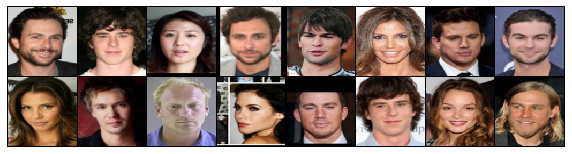

In [18]:

_ = plot_image_grid(next(iter(trainloader))[0])


# B - build  model

In [162]:
num_classes = 10
easy_margin = False

max_epoch = 20
lr = 1e-1  # initial learning rate
lr_step = 10
lr_decay = 0.95  # when val_loss increase, lr = lr*lr_decay
weight_decay = 5e-4


In [4]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out



class ResNet(nn.Module):

    def __init__(self, block, layers ):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                                bias=False)
        ##self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1,
        ##                       bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=2)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.fc5 = nn.Linear(512 * 8 * 8, 512)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # x = nn.AvgPool2d(kernel_size=x.size()[2:])(x)
        # x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc5(x)

        return x


## Training model on softmax lose

In [5]:
def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)

    return model

In [165]:
model = resnet50()

num_ftrs = model.fc5.out_features

metric_fc = nn.Linear(num_ftrs, num_classes )

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(2, 

In [166]:


criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam([{'params': model.parameters()}, {'params': metric_fc.parameters()}],
                                     lr=lr, weight_decay=weight_decay)
scheduler = StepLR(optimizer, step_size=lr_step, gamma=0.1)


In [167]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=max_epoch ): 
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        
        scheduler.step()
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm_notebook(dataloaders[phase]):
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    
                    feature = model(inputs)

                    outputs = metric_fc(feature)                    
                    
                    loss = criterion(outputs, labels)
                    

                    _, preds = torch.max(outputs, 1)
                    

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        
                        optimizer.step()
        

                # statistics

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'test':
                val_acc_history.append(epoch_acc)


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, val_acc_history

In [168]:
model_ft, hist = train_model(model, dataloaders, criterion, optimizer, num_epochs=max_epoch)
torch.save(model_ft.state_dict(), "Resnet/softmax/RasNet.pth")

Epoch 0/19
----------


train Loss: 4619.2625 Acc: 0.1258


test Loss: 2840406.8521 Acc: 0.0947
Epoch 1/19
----------


train Loss: 31.5339 Acc: 0.0985


test Loss: 328.5245 Acc: 0.0710
Epoch 2/19
----------


train Loss: 3.2241 Acc: 0.1061


test Loss: 28.9129 Acc: 0.1065
Epoch 3/19
----------


train Loss: 2.9968 Acc: 0.1333


test Loss: 133.8989 Acc: 0.1006
Epoch 4/19
----------


train Loss: 4.3389 Acc: 0.0879


test Loss: 59.1060 Acc: 0.1006
Epoch 5/19
----------


train Loss: 3.2898 Acc: 0.1045


test Loss: 25.2116 Acc: 0.1183
Epoch 6/19
----------


train Loss: 4.4944 Acc: 0.1061


test Loss: 124.6713 Acc: 0.1243
Epoch 7/19
----------


train Loss: 3.4170 Acc: 0.1121


test Loss: 10.8645 Acc: 0.1065
Epoch 8/19
----------


train Loss: 3.0611 Acc: 0.0818


test Loss: 37.0481 Acc: 0.1302
Epoch 9/19
----------


train Loss: 2.3734 Acc: 0.1076


test Loss: 16.7810 Acc: 0.1302
Epoch 10/19
----------


train Loss: 2.3079 Acc: 0.1136


test Loss: 29.7100 Acc: 0.1361
Epoch 11/19
----------


train Loss: 2.2951 Acc: 0.1258


test Loss: 16.6487 Acc: 0.1183
Epoch 12/19
----------


train Loss: 2.3689 Acc: 0.1167


test Loss: 12.6387 Acc: 0.1243
Epoch 13/19
----------


train Loss: 2.3798 Acc: 0.1197


test Loss: 25.7818 Acc: 0.1065
Epoch 14/19
----------


train Loss: 2.3125 Acc: 0.1212


test Loss: 20.1482 Acc: 0.1302
Epoch 15/19
----------


train Loss: 2.3644 Acc: 0.1197


test Loss: 2.9528 Acc: 0.1302
Epoch 16/19
----------


train Loss: 2.3107 Acc: 0.1091


test Loss: 24.6790 Acc: 0.1302
Epoch 17/19
----------


train Loss: 2.3334 Acc: 0.1152


test Loss: 5.8061 Acc: 0.1006
Epoch 18/19
----------


train Loss: 2.3296 Acc: 0.1273


test Loss: 21.2608 Acc: 0.1361
Epoch 19/19
----------


train Loss: 2.2644 Acc: 0.1348


test Loss: 20.3465 Acc: 0.1302
Training complete in 144m 29s
Best val Acc: 0.136095


## Training model on ArcFace lose

In [359]:
class ArcFace(nn.Module):
    def __init__(self, output, num_class, margin_s=64.0, margin_m=0.50, easy_margin=False):
        super(ArcFace , self).__init__()
        self.num_class = num_class
        self.m = margin_m
        self.s = margin_s
        self.easy_margin = easy_margin
        self.output = output

        self.weight = Parameter(torch.FloatTensor(num_class , output ))
        nn.init.xavier_uniform_(self.weight)


        self.cos_m = math.cos(self.m)
        self.sin_m = math.sin(self.m)
        self.th = math.cos(math.pi - self.m)
        self.mm = math.sin(math.pi - self.m) * self.m


    def forward(self, x , label):

        cos_theta = F.linear(F.normalize(x), F.normalize(self.weight))
        sin_theta = torch.sqrt((1.0 - torch.pow(cos_theta, 2)).clamp(0, 1))
        phi = cos_theta * self.cos_m - sin_theta * self.sin_m

        if self.easy_margin:
            phi = torch.where(cos_theta > 0, phi, cos_theta)
        else:
            phi = torch.where(cos_theta > self.th, phi, cos_theta - self.mm)

        # convert label to one-hot
        one_hot = torch.zeros(cos_theta.size())
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        # where(out_i = {x_i if condition_i else y_i)
        output = one_hot * phi + (1.0 - one_hot) * cos_theta
        output = output * self.s

    return output


In [360]:
model = resnet50()

num_ftrs = model.fc5.out_features

model_fc = ArcFace( num_ftrs , num_classes, margin_s=30, margin_m=0.5, easy_margin=easy_margin)
print(model)

In [361]:
criterion = torch.nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = torch.optim.Adam([{'params': model.parameters()}, {'params': metric_fc.parameters()}],
                                     lr=lr, weight_decay=weight_decay)
scheduler = StepLR(optimizer, step_size=lr_step, gamma=0.1)

In [362]:
model_ft, hist = train_model(model, dataloaders, criterion, optimizer, num_epochs=25)
torch.save(model_ft.state_dict(), "models/ArcFace/RasNet_ArcFace.pth")

# Testing

## 1- load Model

In [6]:
class_num = 87020

model = resnet50()

model.load_state_dict(torch.load("Resnet/SoftMax/RasNet.pth"))

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc5.out_features

model.fc = nn.Linear(num_ftrs, class_num )

model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(2, 

## 2- Dataset - IJB-A Janus

In [32]:
import os, sys, shutil
import random as rd
import struct as st

from PIL import Image
import numpy as np
from scipy import misc

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.autograd import Variable
from torch.nn.modules.loss import _WeightedLoss

def load_imgs(img_dir, image_list_file):
    imgs = list()
    with open(image_list_file, 'r') as imf:
        for line in imf:
            record = line.strip().split()
            
            # path 
            paths = record[0].split("/")[9]
  
            img_path = os.path.join(img_dir,paths)
    
            
            yaw = float(record[1])
            imgs.append((img_path, yaw))
    return imgs


class IJBADataset(data.Dataset):
    
    def __init__(self, img_dir, image_list_file, transform=None):
        
        self.imgs = load_imgs(img_dir, image_list_file)
        self.transform = transform

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        
        path, yaw = self.imgs[idx]
        
        img = Image.open(path).convert("RGB")

        img = self.transform(img)
            
        return img, yaw
    
    def __len__(self):
        return len(self.imgs)

      

In [33]:
split_dir = os.path.join('IJBA/align_image_11/ijb_a_11_align_split1')
img_dir = os.path.join(split_dir, "img")
img_list_file = os.path.join(split_dir, '{}_list_{}.txt'.format("img", "nonli"))

test_transform = T.Compose([
                T.Resize(input_shape[1:]),
                T.ToTensor()])

batch_size = 16
workers= 4

img_dataset =  IJBADataset(img_dir, img_list_file, test_transform)

img_loader = torch.utils.data.DataLoader(
                    img_dataset,
                    batch_size=batch_size, shuffle=False,
                    num_workers=workers, pin_memory=True)
       

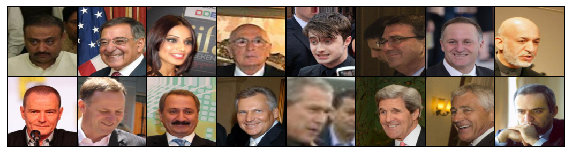

In [34]:
_ = plot_image_grid(next(iter(img_loader))[0])

## 3- Feature extraction

In [72]:
data_num = len(img_dataset)
img_feat_file = os.path.join(split_dir, '{}_{}_feat.bin'.format("resnet50", "img"))
feat_dim = 512
with open(img_feat_file, 'wb') as bin_f:
    bin_f.write(st.pack('ii', data_num, feat_dim))
    i=0
    
    for input, yaw  in img_loader:

        input_var = torch.autograd.Variable(input, volatile=True)
        
        output = model(input)
        output_data = output.data.numpy()
        feat_num  = output.size(0)
        i+=1
        #print("complete :" + str(i) + "/" + str(len(img_loader)))
                    
        for j in range(feat_num):
              bin_f.write(st.pack('f'*feat_dim, *tuple(output_data[j,:])))
        

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # Remove the CWD from sys.path while we load stuff.


## 4-  Verification

In [44]:
import os, sys, shutil
import struct as st
import numpy as np
import bisect
import pickle
from scipy import spatial
from sklearn import metrics 
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
from sklearn.metrics.pairwise import cosine_similarity

def load_meta_data(meta_file):
    meta_data = dict()
    with open(meta_file, 'r') as in_f:
        in_f.readline() # the first line is not data
        for line in in_f:
            record = line.strip().split(',')
            template, class_id, img_path = int(record[0]), int(record[1]), record[2]
            if template not in meta_data:
                meta_data[template] = ( class_id, [img_path,] )
            else:
                meta_data[template][1].append(img_path)
    return meta_data

In [45]:
def load_feat(list_file, bin_file):
    mid_feats = dict()
    with open(list_file, 'r') as list_f, open(bin_file, 'rb') as bin_f:
        (data_num, feat_dim) = st.unpack('ii', bin_f.read(8))
        for line in list_f:
            record = line.strip().split('/')
            img_name = '/'.join(record[-2:])
            feat = np.array(st.unpack('f'*feat_dim, bin_f.read(4*feat_dim)))
            mid_feats[img_name] = feat
    return mid_feats, feat_dim


In [46]:
def update_meta_data(meta_data, feats, feat_dim):
    new_meta_data = dict()
    for template in meta_data.keys():
        class_id, img_names = meta_data[template]
        feat = np.zeros(feat_dim)
        feat_num = 0
        for img_name in img_names:
            if img_name in feats:
                feat += feats[img_name]
                feat_num += 1
        if feat_num > 0: feat /= feat_num
        if feat_num > 0: new_meta_data[template] = (class_id, feat)
    return new_meta_data

In [47]:


# calc_tar2{{{
def calc_tar2(fpr, tpr, method=0):
    if method == 0:
        min_dis, tar2 = 100.0, 1.0
        for i in range(fpr.size):
            if(fpr[i]+tpr[i] > 1.0):
                break
            mid_res = abs(fpr[i]+tpr[i]-1.0)
            if(mid_res < min_dis):
                min_dis = mid_res
                tar2 = fpr[i]
        return tar2
    else:
        f = lambda x: np.interp(x, fpr, tpr)+x-1
        return fsolve(f, 0.0)
#}}}

In [48]:
def eval_roc(pair_file, meta_data, split):
    labels, scores = [], []
    with open(pair_file, 'r') as in_f:
        for line in in_f:
            record = line.strip().split(',')
            temp1, temp2 = int(record[0]),int(record[1])
            if not(temp1 in meta_data and temp2 in meta_data):
                continue
            info1, info2 = meta_data[temp1], meta_data[temp2]
            label = int(info1[0] == info2[0])
            score = 1-spatial.distance.cosine(info1[1],info2[1])
            labels.append(label)
            scores.append(score)
    fpr, tpr, thresholds = metrics.roc_curve(labels, scores)
    idx1 = bisect.bisect_left(fpr,0.01)
    tar1 = tpr[ bisect.bisect_left(fpr,0.001) ]
    tar2 = tpr[ bisect.bisect_left(fpr,0.01)  ]
    
    auc_score = metrics.auc(fpr, tpr)
    
    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, color='blue',
                 label='ROC (AUC = %0.4f)' % auc_score)
    plt.legend(loc='lower right')
    plt.title("ROC Curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.show()
    
    return tar1, tar2

In [76]:
def test_verify():
    
    protocol_dir = 'IJBA/protocol_11'
    align_img_dir = 'IJBA/align_image_11'
    tar1s, tar2s = [],[]
    split = 1
    split_protocol_dir = os.path.join(protocol_dir, 'split'+str(split))
    meta_file = os.path.join(split_protocol_dir, 'verify_metadata_{}.csv'.format(split))
    meta_data = load_meta_data(meta_file)
    # load extract feat
    feats = dict()
    feat_dim = 512
    split_img_dir = os.path.join(align_img_dir, 'ijb_a_11_align_split{}'.format(split))
    list_file = os.path.join(split_img_dir, '{}_list.txt'.format("img"))
    bin_file = os.path.join(split_dir, '{}_{}_feat.bin'.format("resnet50", "img"))
    mid_feats, feat_dim = load_feat(list_file, bin_file)
    feats.update(mid_feats)
    
    # update meta data
    meta_data = update_meta_data(meta_data, feats, feat_dim)

    # eval roc
    pair_file = os.path.join(split_protocol_dir, 'verify_comparisons_{}.csv'.format(split))
    tar1, tar2 = eval_roc(pair_file, meta_data, split)
    tar1s.append(tar1)
    tar2s.append(tar2)
    
    print('split {}, tar1: {}, tar2: {}'.format(split,tar1,tar2))
    print('tar1: {} +/- {}'.format(np.mean(tar1s), np.std(tar1s)))
    print('tar2: {} +/- {}'.format(np.mean(tar2s), np.std(tar2s)))
    
    return np.mean(tar1s), np.std(tar1s), np.mean(tar2s), np.std(tar2s)
    
    

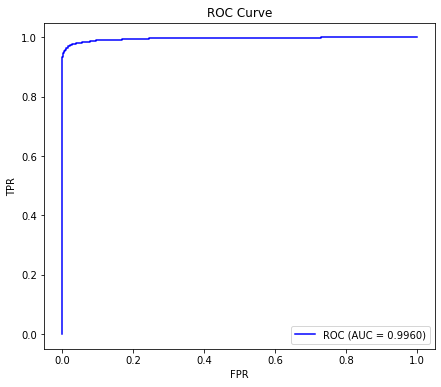

split 1, tar1: 0.8972911963882618, tar2: 0.9582392776523702
tar1: 0.8972911963882618 +/- 0.0
tar2: 0.9582392776523702 +/- 0.0


(0.8972911963882618, 0.0, 0.9582392776523702, 0.0)

In [78]:
test_verify()